In [1]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:

    !pip install gymnasium moviepy optuna

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import optuna
#O sampler do optuna basicamente vai ditar como o optuna vai ajustando os parâmetros a cada iteração
from optuna.samplers import TPESampler # https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html

optuna.logging.set_verbosity(optuna.logging.WARNING) # Para esconder a verbosidade padrão do optuna

c:\Users\Multimegaman\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
VERBOSE = True

# Configurações
# NOME_AMBIENTE = "CliffWalking-v0"
MAXIMO_PASSOS = 9000
TAXA_APRENDIZADO = 0.2
DESCONTO = 0.95
EPSILON = 0.1
TEMPERATURA = 1.0

import envs #importa racetrack
envs = {
    "Racetrack": "RaceTrack-v0",  # ensure this env exists or adjust accordingly
    "Cliffwalking": "CliffWalking-v0",
    "Frozen": "FrozenLake-v1",
    "Taxi": "Taxi-v3"
}

In [4]:
def plot_multiple_results(resultados, log_scale=False):
    for grupo_nome, grupo_dados in resultados.items():

        plt.figure(figsize=(12, 6))
        plt.title(f"Resultados do grupo: {grupo_nome}")

        for politica_nome, recompensas in grupo_dados.items():
            plt.plot(recompensas, label=politica_nome)

        plt.xlabel("Passos")
        plt.ylabel("Recompensas")
        if log_scale:
            plt.yscale('log')
        plt.legend()
        plt.show()

In [5]:
# Politicas

def politica_epsilon_gulosa(Q, estado, num_acoes, epsilon):
    probabilidades = [ (epsilon / num_acoes) ] * num_acoes
    acao_gulosa = np.argmax(Q[estado])
    probabilidades[acao_gulosa] += (1.0 - epsilon)
    return probabilidades

def politica_softmax(Q, estado, temperatura=1.0):
    valores_exp = np.exp(Q[estado] / temperatura)
    return valores_exp / np.sum(valores_exp)

def selecionar_acao(Q, estado, politica, **kwargs):
    probabilidades = politica(Q, estado, **kwargs)
    return np.random.choice(len(probabilidades), p=probabilidades)

In [ ]:
def executar_expected_sarsa(ambiente, max_passos, taxa_aprendizado=0.1, desconto=0.95,
                          politica_treinamento=politica_epsilon_gulosa, politica_alvo=politica_epsilon_gulosa,
                          parametros_politica=None, exibir=False):
    num_acoes = ambiente.action_space.n
    Q = np.zeros((ambiente.observation_space.n, num_acoes))
    recompensas_por_episodio = []

    parametros_politica = parametros_politica or {}

    for i in tqdm(range(max_passos), desc=("Treinando Expected-SARSA -" + politica_treinamento.__name__ + " x " + politica_alvo.__name__)):
        concluido = False
        recompensa_total = 0
        estado, _ = ambiente.reset()
        passos = 0  # Inicializa o contador de passos

        while not concluido and passos < 3000:  # Limita os passos dentro de cada episódio
            if exibir and (i >= (max_passos - 5) or (i+1) % 1000 == 0):
                ambiente.render()

            acao = selecionar_acao(Q, estado, politica_treinamento, **parametros_politica)
            proximo_estado, recompensa, terminou, truncado, _ = ambiente.step(acao)
            concluido = terminou or truncado

            # Cálculo do valor esperado usando a política alvo
            if terminou:
                valor_proximo_estado = 0
            else:
                prob_alvo = politica_alvo(Q, proximo_estado, **parametros_politica)
                valor_proximo_estado = np.sum(prob_alvo * Q[proximo_estado])

            # Atualização Q-value
            delta = (recompensa + desconto * valor_proximo_estado) - Q[estado, acao]
            Q[estado, acao] += taxa_aprendizado * delta

            recompensa_total += recompensa
            estado = proximo_estado
            passos += 1

        recompensas_por_episodio.append(recompensa_total)
    print("Treinamento concluído. Resultado médio: ", np.mean(recompensas_por_episodio))
    return recompensas_por_episodio, Q

In [7]:
# Função objetivo para ser otimizada pelo Optuna
def objective(trial, env_name, policy_name, max_passos):
    """Função objetivo para otimização de hiperparâmetros com Optuna"""
    taxa_aprendizado = trial.suggest_float('taxa_aprendizado', 1e-3, 0.5, log=True)
    desconto = trial.suggest_float('desconto', 0.8, 0.999)
    
    params = {
        'taxa_aprendizado': taxa_aprendizado,
        'desconto': desconto,
    }
    
    # Hiperparâmetros específicos por política
    if policy_name == "epsilon-gulosa":
        params['epsilon'] = trial.suggest_float('epsilon', 0.01, 0.5)
    elif policy_name == "softmax":
        params['temperatura'] = trial.suggest_float('temperatura', 0.1, 10.0)
    
    # Configurar ambiente e políticas
    ambiente = gym.make(env_name, max_episode_steps=500)
    politicas = {
        "softmax": lambda Q, s, **kw: politica_softmax(Q, s, kw['temperatura']),
        "aleatoria": lambda Q, s, **kw: np.ones(len(Q[s])) / len(Q[s]),
        "epsilon-gulosa": lambda Q, s, **kw: politica_epsilon_gulosa(Q, s, len(Q[s]), kw['epsilon']),
    }
    
    # Executar treino com parâmetros atuais
    recompensas, _ = executar_expected_sarsa(
        ambiente, 
        max_passos= max_passos,
        taxa_aprendizado=params['taxa_aprendizado'],
        desconto=params['desconto'],
        politica_treinamento=politicas[policy_name],
        politica_alvo=politicas[policy_name],
        parametros_politica=params,
        exibir=False
    )
    
    return np.mean(recompensas[-100:])  # Média das últimas 100 recompensas

In [ ]:
def otimizar_hiperparametros(envs, n_trials=50, max_passos=1000):
    """Otimiza hiperparâmetros para cada ambiente e política"""
    best_params = {}
    
    for env_label, env_name in envs.items():
        print(f"\n=== Otimizando {env_label} ===")
        env_params = {}
        
        for policy in ["epsilon-gulosa", "softmax", "aleatoria"]:
            study = optuna.create_study(
                direction='maximize',
                sampler=TPESampler(seed=42),
                pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
            )
            study.optimize(
                lambda trial: objective(trial, env_name, policy, max_passos),
                n_trials=n_trials,
                show_progress_bar=False,  # Desativa a barra de progresso
                n_jobs= 1
            )
            
            # Armazenar melhores parâmetros
            env_params[policy] = {
                **study.best_params,
                'taxa_aprendizado': study.best_params['taxa_aprendizado'],
                'desconto': study.best_params['desconto']
            }
        
        best_params[env_label] = env_params
        print(f"Melhores parâmetros para {env_label}: {env_params}")
    
    return best_params

In [9]:
def executar_experimentos(nome_ambiente, best_params):
    """Executa experimentos com os melhores parâmetros encontrados"""
    ambiente = gym.make(nome_ambiente, max_episode_steps=500)
    politicas = {
        "epsilon-gulosa": lambda Q, s, **kw: politica_epsilon_gulosa(Q, s, len(Q[s]), kw['epsilon']),
        "softmax": lambda Q, s, **kw: politica_softmax(Q, s, kw['temperatura']),
        "aleatoria": lambda Q, s, **kw: np.ones(len(Q[s])) / len(Q[s])
    }

    grupos = [
        ("1) TODOS x random", "aleatoria"),
        ("2) TODOS x epsilon-greedy", "epsilon-gulosa"),
        ("3) TODOS x softmax", "softmax")
    ]

    resultados = {}

    for nome_grupo, politica_alvo_nome in grupos:
        print(f"\n=== {nome_grupo} ===")
        grupo_resultados = {}

        for politica_treinamento_nome in politicas:
            # Usar parâmetros do treino (taxa, desconto) e parâmetros específicos da política alvo
            params = {
                **best_params[politica_treinamento_nome],  # taxa_aprendizado e desconto
                **best_params[politica_alvo_nome]         # adiciona parâmetros da política alvo (epsilon/temperatura)
            }

            recompensas, _ = executar_expected_sarsa(
                ambiente, 
                MAXIMO_PASSOS,
                taxa_aprendizado=params['taxa_aprendizado'],
                desconto=params['desconto'],
                politica_treinamento=politicas[politica_treinamento_nome],
                politica_alvo=politicas[politica_alvo_nome],
                parametros_politica=params  # Garante que 'epsilon' ou 'temperatura' estejam presentes
            )
            
            grupo_resultados[politica_treinamento_nome] = recompensas
        
        resultados[nome_grupo] = grupo_resultados
    
    return resultados

In [10]:
import matplotlib.pyplot as plt
from util.plot import smooth  # use the smooth function from util/plot.py

def plot_grouped_results(resultados, log_scale=False, smooth_window=None):
    num_groups = len(resultados)
    # Cria um subplot para cada grupo na mesma figura
    fig, axes = plt.subplots(1, num_groups, figsize=(6 * num_groups, 5)) if num_groups > 1 else plt.subplots(figsize=(6, 5))
    if num_groups == 1:
        axes = [axes]
        
    for ax, (grupo_nome, grupo_dados) in zip(axes, resultados.items()):
         ax.set_title(f"Resultados do grupo: {grupo_nome}")
         for politica_nome, recompensas in grupo_dados.items():
              # Aplicar o suavizamento se solicitado
              data = smooth(recompensas, smooth_window) if smooth_window is not None else recompensas
              ax.plot(data, label=politica_nome)
         ax.set_xlabel("Passos")
         ax.set_ylabel("Recompensas")
         if log_scale:
             ax.set_yscale("log")
         ax.legend()
    plt.tight_layout()
    plt.show()


=== Otimizando Racetrack ===


Treinando Expected-SARSA: 100%|██████████| 1000/1000 [00:07<00:00, 139.30it/s]


Treinamento concluído. Resultado médio:  -141.641


Treinando Expected-SARSA: 100%|██████████| 1000/1000 [00:10<00:00, 96.69it/s]


Treinamento concluído. Resultado médio:  -187.487


Treinando Expected-SARSA: 100%|██████████| 1000/1000 [00:09<00:00, 104.24it/s]


Treinamento concluído. Resultado médio:  -191.851
Melhores parâmetros para Racetrack: {'epsilon-gulosa': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733, 'epsilon': 0.3686770314875885}, 'softmax': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733, 'temperatura': 7.34674002393291}, 'aleatoria': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733}}

=== Otimizando Cliffwalking ===


Treinando Expected-SARSA: 100%|██████████| 1000/1000 [00:03<00:00, 328.09it/s]


Treinamento concluído. Resultado médio:  -167.158


Treinando Expected-SARSA: 100%|██████████| 1000/1000 [00:09<00:00, 105.29it/s]


Treinamento concluído. Resultado médio:  -281.408


Treinando Expected-SARSA: 100%|██████████| 1000/1000 [00:18<00:00, 52.84it/s]


Treinamento concluído. Resultado médio:  -4948.95
Melhores parâmetros para Cliffwalking: {'epsilon-gulosa': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733, 'epsilon': 0.3686770314875885}, 'softmax': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733, 'temperatura': 7.34674002393291}, 'aleatoria': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733}}

=== Otimizando Frozen ===


Treinando Expected-SARSA: 100%|██████████| 1000/1000 [00:00<00:00, 2399.18it/s]


Treinamento concluído. Resultado médio:  0.024


Treinando Expected-SARSA: 100%|██████████| 1000/1000 [00:00<00:00, 2939.76it/s]


Treinamento concluído. Resultado médio:  0.009


Treinando Expected-SARSA: 100%|██████████| 1000/1000 [00:00<00:00, 3357.68it/s]


Treinamento concluído. Resultado médio:  0.009
Melhores parâmetros para Frozen: {'epsilon-gulosa': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733, 'epsilon': 0.3686770314875885}, 'softmax': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733, 'temperatura': 7.34674002393291}, 'aleatoria': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733}}

=== Otimizando Taxi ===


Treinando Expected-SARSA: 100%|██████████| 1000/1000 [00:13<00:00, 74.10it/s]


Treinamento concluído. Resultado médio:  -680.301


Treinando Expected-SARSA: 100%|██████████| 1000/1000 [00:20<00:00, 47.73it/s]


Treinamento concluído. Resultado médio:  -1326.719


Treinando Expected-SARSA: 100%|██████████| 1000/1000 [00:19<00:00, 50.36it/s]


Treinamento concluído. Resultado médio:  -1816.647
Melhores parâmetros para Taxi: {'epsilon-gulosa': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733, 'epsilon': 0.3686770314875885}, 'softmax': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733, 'temperatura': 7.34674002393291}, 'aleatoria': {'taxa_aprendizado': 0.010253509690168494, 'desconto': 0.9891921469755733}}

=== Executando experimentos para Racetrack ===

=== 1) TODOS x random ===


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:57<00:00, 156.69it/s]


Treinamento concluído. Resultado médio:  -127.57977777777778


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [01:26<00:00, 103.60it/s]


Treinamento concluído. Resultado médio:  -180.38244444444445


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [01:24<00:00, 106.25it/s]


Treinamento concluído. Resultado médio:  -187.91955555555555

=== 2) TODOS x epsilon-greedy ===


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:58<00:00, 154.43it/s]


Treinamento concluído. Resultado médio:  -128.1611111111111


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [01:32<00:00, 97.01it/s] 


Treinamento concluído. Resultado médio:  -184.40755555555555


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [01:31<00:00, 98.12it/s] 


Treinamento concluído. Resultado médio:  -190.1501111111111

=== 3) TODOS x softmax ===


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [01:00<00:00, 149.81it/s]


Treinamento concluído. Resultado médio:  -127.71522222222222


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [01:31<00:00, 98.87it/s] 


Treinamento concluído. Resultado médio:  -183.13377777777777


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [01:29<00:00, 100.90it/s]


Treinamento concluído. Resultado médio:  -184.7122222222222

=== Executando experimentos para Cliffwalking ===

=== 1) TODOS x random ===


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:14<00:00, 601.67it/s]


Treinamento concluído. Resultado médio:  -75.21744444444444


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:28<00:00, 315.70it/s]


Treinamento concluído. Resultado médio:  -89.1528888888889


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [02:46<00:00, 54.07it/s]


Treinamento concluído. Resultado médio:  -4973.1033333333335

=== 2) TODOS x epsilon-greedy ===


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:11<00:00, 792.66it/s] 


Treinamento concluído. Resultado médio:  -69.24044444444445


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:46<00:00, 195.27it/s]


Treinamento concluído. Resultado médio:  -130.85444444444445


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [02:54<00:00, 51.56it/s]


Treinamento concluído. Resultado médio:  -4951.049888888889

=== 3) TODOS x softmax ===


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:14<00:00, 622.00it/s]


Treinamento concluído. Resultado médio:  -165.24277777777777


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:35<00:00, 254.33it/s]


Treinamento concluído. Resultado médio:  -101.75577777777778


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [03:00<00:00, 49.92it/s]


Treinamento concluído. Resultado médio:  -4982.498111111111

=== Executando experimentos para Frozen ===

=== 1) TODOS x random ===


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:03<00:00, 2520.24it/s]


Treinamento concluído. Resultado médio:  0.05433333333333333


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:02<00:00, 3115.85it/s]


Treinamento concluído. Resultado médio:  0.014777777777777779


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:02<00:00, 3347.69it/s]


Treinamento concluído. Resultado médio:  0.014777777777777779

=== 2) TODOS x epsilon-greedy ===


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:03<00:00, 2625.49it/s]


Treinamento concluído. Resultado médio:  0.041555555555555554


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:02<00:00, 3007.06it/s]


Treinamento concluído. Resultado médio:  0.013888888888888888


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:02<00:00, 3232.34it/s]


Treinamento concluído. Resultado médio:  0.013

=== 3) TODOS x softmax ===


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:05<00:00, 1782.92it/s]


Treinamento concluído. Resultado médio:  0.067


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:03<00:00, 2958.63it/s]


Treinamento concluído. Resultado médio:  0.01411111111111111


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:02<00:00, 3119.66it/s]


Treinamento concluído. Resultado médio:  0.015

=== Executando experimentos para Taxi ===

=== 1) TODOS x random ===


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [01:01<00:00, 145.49it/s]


Treinamento concluído. Resultado médio:  -329.5212222222222


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [02:09<00:00, 69.27it/s] 


Treinamento concluído. Resultado médio:  -834.2521111111112


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [02:56<00:00, 51.02it/s]


Treinamento concluído. Resultado médio:  -1824.0268888888888

=== 2) TODOS x epsilon-greedy ===


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:42<00:00, 209.83it/s]


Treinamento concluído. Resultado médio:  -223.66533333333334


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [01:56<00:00, 77.44it/s] 


Treinamento concluído. Resultado médio:  -687.1737777777778


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [03:07<00:00, 48.04it/s]


Treinamento concluído. Resultado médio:  -1817.6792222222223

=== 3) TODOS x softmax ===


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:53<00:00, 169.10it/s]


Treinamento concluído. Resultado médio:  -264.44733333333335


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [02:06<00:00, 71.21it/s] 


Treinamento concluído. Resultado médio:  -751.0646666666667


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [03:09<00:00, 47.57it/s]


Treinamento concluído. Resultado médio:  -1816.5346666666667

=== Resultados para Racetrack ===


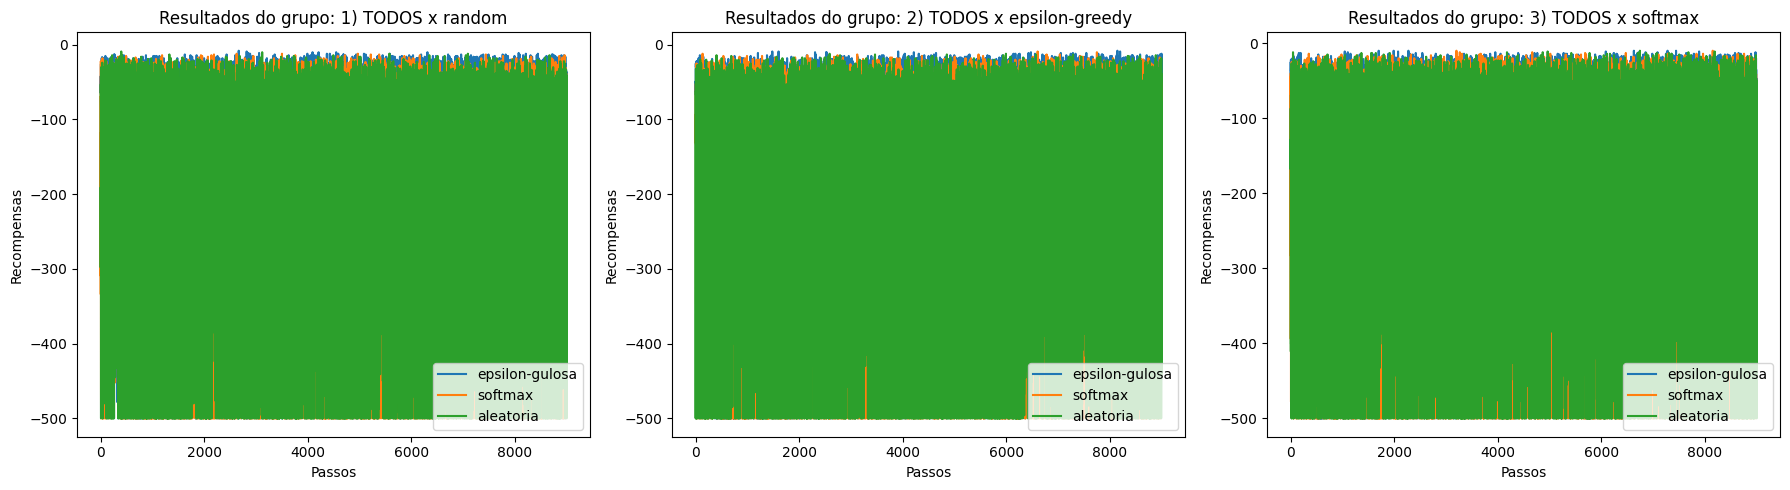


=== Resultados para Cliffwalking ===


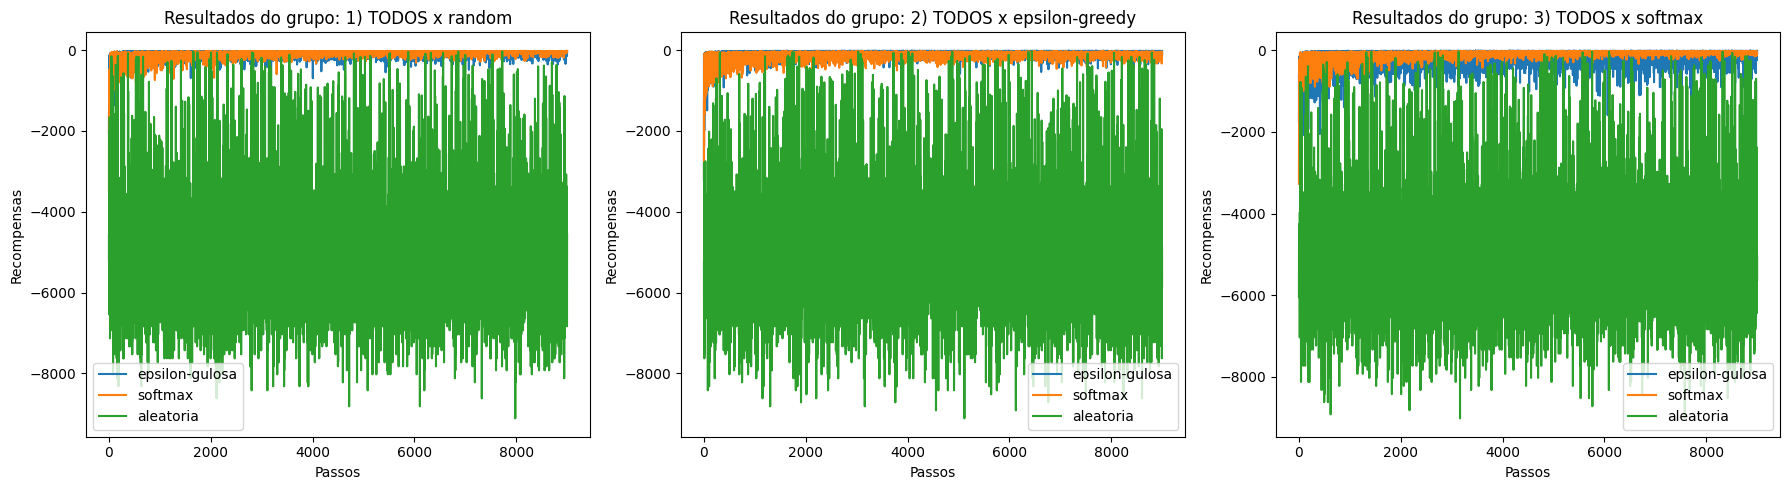


=== Resultados para Frozen ===


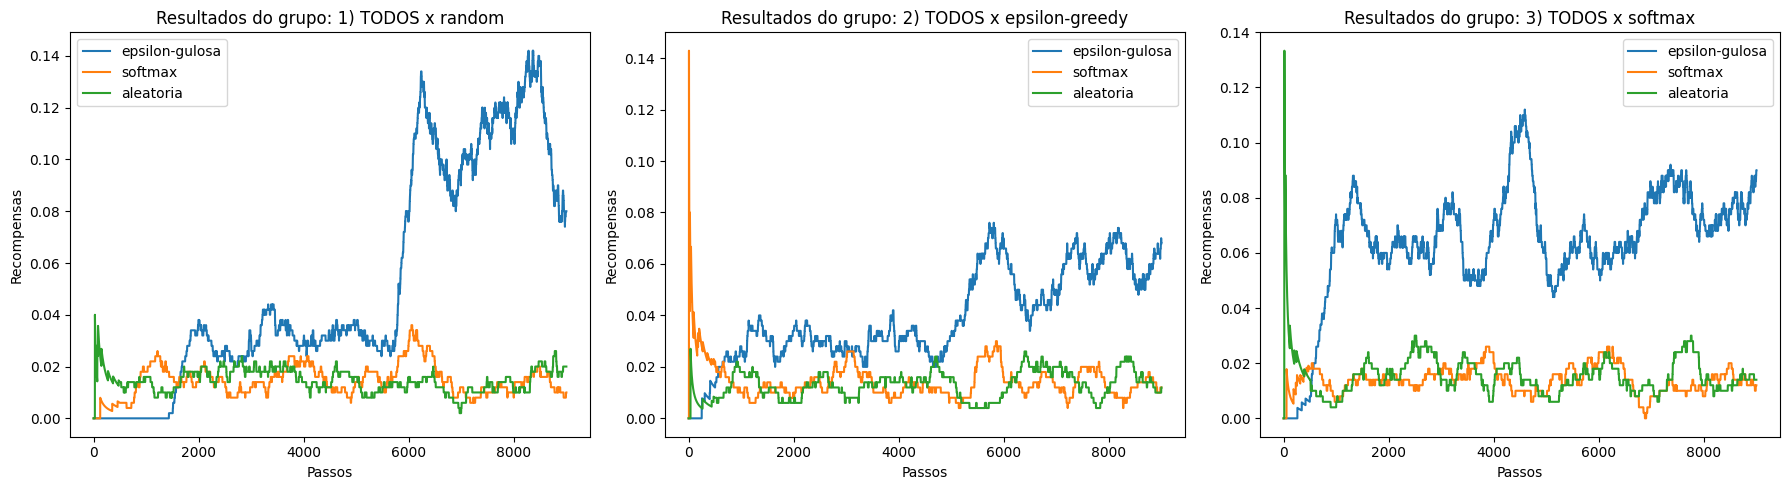


=== Resultados para Taxi ===


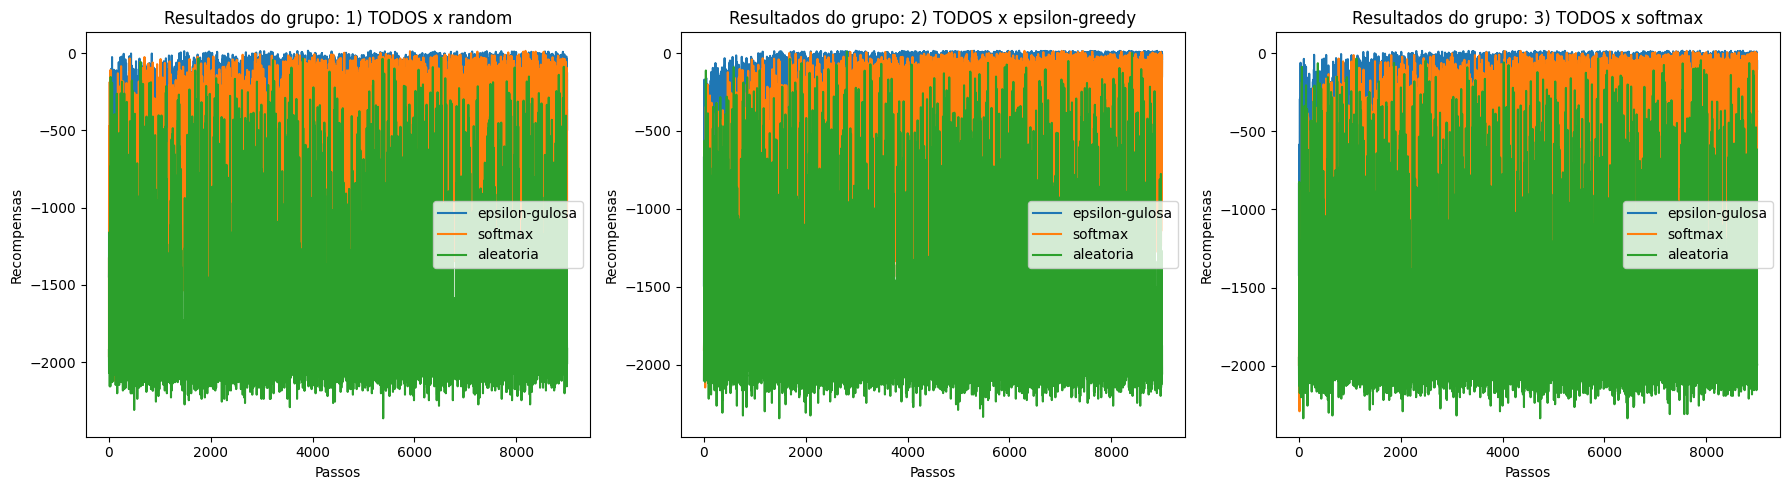

In [11]:
# Fase 1: Otimização de hiperparâmetros
best_params = otimizar_hiperparametros(envs, n_trials=1, max_passos=1000)
# Fase 2: Execução dos experimentos com parâmetros otimizados
results_per_env = {}

for env_label, env_name in envs.items():
    #Pegando os melhores parâmetros para cada ambiente
    print(f"\n=== Executando experimentos para {env_label} ===")
    results = executar_experimentos(env_name, best_params[env_label])
    results_per_env[env_label] = results

# Fase 3: Plotagem dos resultados
for env_label, env_results in results_per_env.items():
    print(f"\n=== Resultados para {env_label} ===")
    if env_label == "Frozen":
        plot_grouped_results(env_results, log_scale=False, smooth_window=500)
    else:
        plot_grouped_results(env_results, log_scale=False)